In [1]:
# -*- coding: utf-8 -*-
import dataiku
import pandas as pd, numpy as np
from dataiku import pandasutils as pdu

from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import time

t0 = time.time()
print("loading...")

# Read recipe inputs
NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT = dataiku.Dataset("NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT")
NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT_df = NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT.get_dataframe()

NAFCUSTOMER_REVENUE_AGGREGATED = dataiku.Dataset("NAFCUSTOMER_REVENUE_AGGREGATED")
NAFCUSTOMER_REVENUE_AGGREGATED_df = NAFCUSTOMER_REVENUE_AGGREGATED.get_dataframe()

t1 = time.time()
print("load duration", (t1-t0)/60.0, "minutes")

loading...
load duration 10.09039772748947 minutes


In [6]:
# copy input datasets
# this allows us to reset the analysis without having to reload the datasets from the database
print(len(NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT_df), "rows in NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT")
df_a = NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT_df.copy()

print(len(NAFCUSTOMER_REVENUE_AGGREGATED_df), "rows in NAFCUSTOMER_REVENUE_AGGREGATED")
df = NAFCUSTOMER_REVENUE_AGGREGATED_df.copy()
# remove 2023 from the analysis as this is a partial year
df = df[df.REVENUE_YEAR!=2023]
print(len(df))

2319568 rows in NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT
18075044 rows in NAFCUSTOMER_REVENUE_AGGREGATED
17673397


In [4]:

# Group sum of revenue by customer and year 
df_revenue_by_customer_and_year = df.groupby(['CUSTOMER_ID','CUSTOMER','REVENUE_YEAR']).REVENUE_AMOUNT_USD.sum().reset_index()
print(len(df_revenue_by_customer_and_year))

# Group sum of spend by customer and year
df_spend_by_customer_and_year = df.groupby(['CUSTOMER_ID','CUSTOMER','REVENUE_YEAR']).GROSS_SPEND_AMOUNT.sum().reset_index()
print(len(df_spend_by_customer_and_year))

# Group active card count by customer and year
df_active_card_count_by_customer = df_a.groupby(['CUSTOMER_ID','CUSTOMER','YEAR_NUMBER']).ACTIVE_CARD_COUNT.sum().reset_index()
df_active_card_count_by_customer.columns = ['CUSTOMER_ID','CUSTOMER','REVENUE_YEAR','ACTIVE_CARD_COUNT']
print(len(df_active_card_count_by_customer))

# Assign max active card count year by customer
# This is the fleet size of the customer
df_customer_fleet_size = df_active_card_count_by_customer.groupby(['CUSTOMER_ID','CUSTOMER']).ACTIVE_CARD_COUNT.max().reset_index()
df_customer_fleet_size.columns = ['CUSTOMER_ID', 'CUSTOMER', 'FLEET_SIZE']
print(len(df_customer_fleet_size))

1777729
1777729
1771976
649448


In [7]:
# Join datasets together in order to create combined metrics at customer and year grain
print(len(df_revenue_by_customer_and_year))
df_j = pd.merge(df_revenue_by_customer_and_year,df_spend_by_customer_and_year,how='left',on=['CUSTOMER_ID','CUSTOMER','REVENUE_YEAR'])
print(len(df_j))

df_j = pd.merge(df_j,df_active_card_count_by_customer,how='left',on=['CUSTOMER_ID','CUSTOMER','REVENUE_YEAR'])
print(len(df_j))

df_j = pd.merge(df_j,df_customer_fleet_size, how='left',on=['CUSTOMER_ID','CUSTOMER'])
print(len(df_j))

df_j.loc[df_j.ACTIVE_CARD_COUNT.isnull(),'ACTIVE_CARD_COUNT'] = 0
df_j.loc[df_j.FLEET_SIZE.isnull(),'FLEET_SIZE'] = 0

df_j['FLEET_CATEGORY'] = 'NOT SET'
df_j.loc[df_j.FLEET_SIZE.between(0,5),'FLEET_CATEGORY'] = '(<=5 cards)'
df_j.loc[df_j.FLEET_SIZE.between(6,100),'FLEET_CATEGORY'] = '(between 6 and 100 cards)'
df_j.loc[df_j.FLEET_SIZE>50,'FLEET_CATEGORY'] = '(>100 cards)'
df_j.head()

1777729
1777729
1777729
1777729


,CUSTOMER_ID,CUSTOMER,REVENUE_YEAR,REVENUE_AMOUNT_USD,GROSS_SPEND_AMOUNT,ACTIVE_CARD_COUNT,FLEET_SIZE,FLEET_CATEGORY
0,77000000.0,1 AUTO PARTS INC,2019,175.47,0.00,1.0,1.0,(<=5 cards)
1,77000001.0,94775 J AND J SNACK FOODS AA,2022,74.15,3318.62,3.0,3.0,(<=5 cards)
2,77000002.0,APOSTROPHE DESIGN INC,2019,177.47,8944.23,4.0,8.0,(between 6 and 100 cards)
3,77000002.0,APOSTROPHE DESIGN INC,2020,271.60,10358.34,4.0,8.0,(between 6 and 100 cards)
4,77000002.0,APOSTROPHE DESIGN INC,2021,243.51,13094.44,8.0,8.0,(between 6 and 100 cards)


NameError: name 'FuncFormatter' is not defined

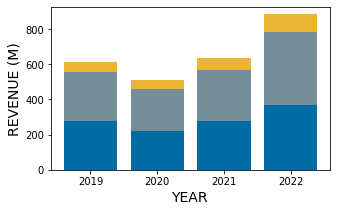

In [10]:
def stacked_bar(series):
    
    fig, ax = plt.subplots(1, figsize=(5,3))
    divider = 1000000
    
    max_value = 0
    bottom = len(df_revenue_by_year.REVENUE_YEAR.unique()) * [0]
    for idx,s in enumerate(labels):
        
        dim1 = list(map(str,df_revenue_by_year[df_revenue_by_year.FLEET_CATEGORY==s].REVENUE_YEAR))
        data1 = df_revenue_by_year[df_revenue_by_year.FLEET_CATEGORY==s].REVENUE_AMOUNT_USD/divider
    
        ax.bar(dim1, data1, bottom=bottom, color=colors[idx])
        bottom = [sum(i) for i in zip(data1, bottom )] 
    
    ax.set_xlabel('YEAR', fontsize=14)
    ax.set_ylabel('REVENUE (M)', fontsize=14)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.grid(color='#95a5a6', linestyle='--', linewidth=1, axis='y', alpha=0.6)
    fig.autofmt_xdate()
    plt.title('REVENUE BY FLEET SIZE')
    plt.legend(labels, bbox_to_anchor=(1.05,1.0), loc='upper left')
    plt.show()
    
series = [1,2,3,4,5]
colors = ['#006BA2','#758D99','#EBB434']
labels = ['(>100 cards)','(between 6 and 100 cards)','(<=5 cards)']

df_revenue_by_year = df_j.groupby(['REVENUE_YEAR','FLEET_CATEGORY']).REVENUE_AMOUNT_USD.sum().reset_index()
#f_revenue_by_year.head()

stacked_bar(series)

In [0]:
# Compute recipe outputs
# TODO: Write here your actual code that computes the outputs
# NB: DSS supports several kinds of APIs for reading and writing data. Please see doc.

#RETENTION_RATE_df = ... # Compute a Pandas dataframe to write into RETENTION_RATE


# Write recipe outputs
#RETENTION_RATE = dataiku.Dataset("RETENTION_RATE")
#RETENTION_RATE.write_with_schema(RETENTION_RATE_df)